# Customer Lifetime Value Estimation Using a Bayesian Buy-Till-You-Die (BTYD) Model

This notebooks provides a customer lifetime value (CLTV) model for non-contractual environments such as retail. 

### Use Case
We assume a non-contractual environment where each customer is represented by a history of purchases (orders, transactions). Each purchase is associated with a timestamp and monetary value. Our goal is to build a model that helps to answer the following questions for an individual customer given her purchase history:
* What the expected number of purchases for a given time horizon?
* What is the expected average purchase value?
* What the estimated LTV for a given time horizon?

### Prototype: Approach and Data
We assume that each customer is represented by the summary metrics (RFM metrics) that are computed based on the purchase histories for a certain time moment `t`:
* `T` - time since the first purchase (customer age) 
* `recency` - time since the last purchase
* `frequency` - total number of purchases
* `monetary_value` - total of all past purchases

We use a data sample with these metrics precomputed for a population of customers. This dataset is available in the `tensor-house-data` repository.

The prototype includes two Bayesian models:
* Purchase frequency model. This model predicts the likelihood of a customer being active and their transaction frequency. We use the BG/NBD model described in [1-3] which belongs to the Buy-Till-You-Die (BTYD) model family.
* Average Order Value. This model predicts the average order value of a customer. We use the Gamma-Gamma model described in [4]. 

The implementation is based on [4] and includes multiple simplifications to make the prototype more readable and customizable.

### Usage and Productization
The BG/NBD and Gamma-Gamma models are commonly used for implementing enterprise-grade CLTV models, so this prototype can be used as a starting point for creating production solutions. It is recommended to test and tune the solution on a small sample and then scale. 

### References
1. Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). “Counting your customers” the easy way: An alternative to the Pareto/NBD model. Marketing science, 24(2), 275-284. ([pdf](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf))
2. Fader, P. S., Hardie, B. G., & Lee, K. L. (2008). Computing P (alive) using the BG/NBD model. ([pdf](http://www.brucehardie.com/notes/021/palive_for_BGNBD.pdf))
3. Fader, P. S. & Hardie, B. G. (2013) Overcoming the BG/NBD Model’s #NUM! Error Problem. Research ([pdf](http://brucehardie.com/notes/027/bgnbd_num_error.pdf))
4. Fader, P. S. & Hardie, B. G. (2013) The Gamma-Gamma Model of Monetary Value. ([pdf](https://www.brucehardie.com/notes/025/gamma_gamma.pdf))
5. PyMC Marketing https://github.com/pymc-labs/pymc-marketing

In [102]:
#
# Imports and settings
#
from tabulate import tabulate

import numpy as np
import pandas as pd

import pymc as pm
import pytensor.tensor as pt
from scipy.special import hyp2f1

import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
print(f'{multiprocessing.cpu_count()} CPUs available')

#
# Helper functions
#
def print_df(df, rows = 10):
    print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')

12 CPUs available


## Data Loading

The input is a collection of customer records where each record is represented by RFM metrics.  

In [156]:
#
# Recency, frequency, and T are in days
#
rfm_df = pd.read_csv('../../tensor-house-data/promotions/online-retail-rfm/online_retail_rmf.csv.zip')
print_df(rfm_df)
print(f"Number of customer without transaction: {len(rfm_df[rfm_df['frequency']==0])}")
print(f"Number of customer with zero revenue: {len(rfm_df[rfm_df['monetary_value']==0])}")

+----+---------------+-------------+-----------+-----+------------------+
|    |   customer_id |   frequency |   recency |   T |   monetary_value |
|----+---------------+-------------+-----------+-----+------------------|
|  0 |         12347 |           7 |       365 | 367 |          615.714 |
|  1 |         12348 |           4 |       283 | 358 |          449.31  |
|  2 |         12349 |           1 |         0 |  18 |         1757.55  |
|  3 |         12350 |           1 |         0 | 310 |          334.4   |
|  4 |         12352 |           6 |       260 | 296 |          234.213 |
|  5 |         12353 |           1 |         0 | 204 |           89     |
|  6 |         12354 |           1 |         0 | 232 |         1079.4   |
|  7 |         12355 |           1 |         0 | 214 |          459.4   |
|  8 |         12356 |           3 |       303 | 325 |          937.143 |
|  9 |         12357 |           1 |         0 |  33 |         6207.67  |
+----+---------------+-------------+--

## Step 1: Purchase Frequency Model

In this section, we specify and fit the BG/NBD model. We also show how it can be used to forecast the expected number of purchases for specific customers or RFM cohorts.

In [150]:
#
# Specify and fit the model
#
def build_bg_nbd_model(data: pd.DataFrame):
    frequency = data["frequency"]
    recency = data["recency"]
    T = data["T"]
    coords = {"customer_id": data["customer_id"]}
    
    # Setting priors
    a_prior = pm.HalfNormal.dist(sigma=10)
    b_prior = pm.HalfNormal.dist(sigma=10)
    alpha_prior = pm.HalfNormal.dist(sigma=10)
    r_prior = pm.HalfNormal.dist(sigma=10)
    
    with pm.Model(coords=coords) as model:
            a = model.register_rv(a_prior, name="a")
            b = model.register_rv(b_prior, name="b")
            alpha = model.register_rv(alpha_prior, name="alpha")
            r = model.register_rv(r_prior, name="r")

            def logp(t_x, x, a, b, r, alpha, T):
                # The log-likelihood expression here aligns with expression (4) from [3]
                x_non_zero = x > 0

                # Refactored for numerical error
                d1 = (
                    pt.gammaln(r + x)
                    - pt.gammaln(r)
                    + pt.gammaln(a + b)
                    + pt.gammaln(b + x)
                    - pt.gammaln(b)
                    - pt.gammaln(a + b + x)
                )

                d2 = r * pt.log(alpha) - (r + x) * pt.log(alpha + t_x)
                c3 = ((alpha + t_x) / (alpha + T)) ** (r + x)
                c4 = a / (b + x - 1)

                logp = d1 + d2 + pt.log(c3 + pt.switch(x_non_zero, c4, 0))

                return logp

            pm.Potential(
                "likelihood",
                logp(
                    x=frequency,
                    t_x=recency,
                    a=a,
                    b=b,
                    alpha=alpha,
                    r=r,
                    T=T,
                ),
            )
    return model
            
model_purchase_freq = build_bg_nbd_model(rfm_df)
idata_purchase_freq = pm.sample(model=model_purchase_freq, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


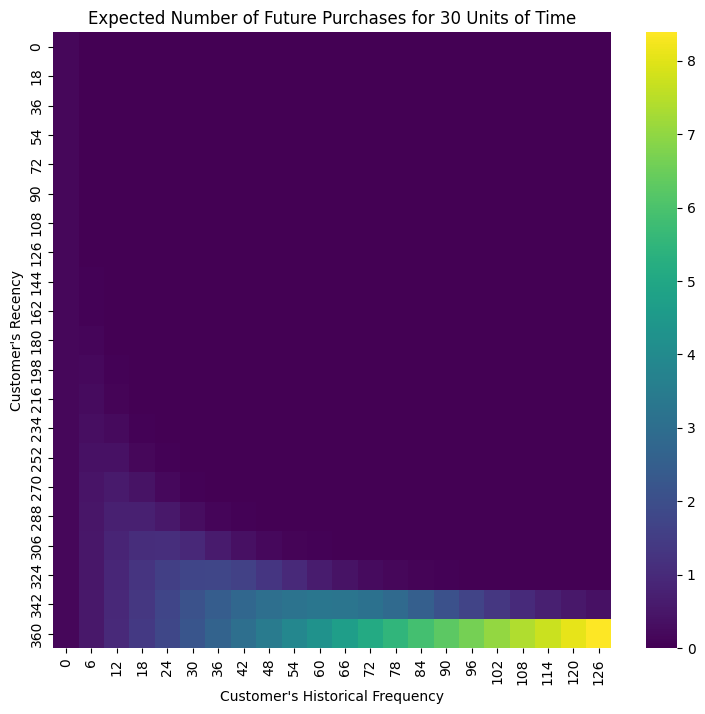

In [164]:
#
# Estimate the expected number of future purchases for 
# an individual customer in the time interval of length (T, T + t]
# The closed form solution for this equation is available as (10) from [1]
#
def expected_num_purchases(t, frequency, recency, T, idata):
    trace = idata.posterior
    a, b, alpha, r = trace["a"], trace["b"], trace["alpha"], trace["r"]
    
    numerator = 1 - ((alpha + T) / (alpha + T + t)) ** (r + frequency) * hyp2f1(
            r + frequency,
            b + frequency,
            a + b + frequency - 1,
            t / (alpha + T + t),
    )
    numerator *= (a + b + frequency - 1) / (a - 1)
    denominator = 1 + (frequency > 0) * (a / (b + frequency - 1)) * (
        (alpha + T) / (alpha + recency)
    ) ** (r + frequency)

    return (numerator / denominator).transpose(
        "chain", "draw", missing_dims="ignore"
    )

#
# Visualize the expected number of purchase for frequency x recency cohorts
#
t = 30 # one month time horizon

mesh_steps = 20
max_recency = rfm_df['recency'].max().astype(int)
max_frequency = rfm_df['frequency'].max().astype(int)

recency_mesh = np.arange(max_recency, step=int(max_recency/mesh_steps))
frequency_mesh = np.arange(max_frequency, step=int(max_frequency/mesh_steps))
z = np.zeros([len(recency_mesh), len(frequency_mesh)])
for i, recency in enumerate(recency_mesh):
    for j, frequency in enumerate(frequency_mesh):
        z[i, j] = (
            expected_num_purchases(
                t=t,
                frequency=frequency,
                recency=recency,
                T=max_recency,              # we assume that all customers made the first transaction -max_recency steps ago
                idata=idata_purchase_freq
            ).mean(("draw", "chain")).item()
        )

_, ax = plt.subplots(1, 1, figsize=(9, 8))
pcm = sns.heatmap(pd.DataFrame(z, index=recency_mesh, columns=frequency_mesh), cmap='viridis')
ax.set(
        xlabel="Customer's Historical Frequency",
        ylabel="Customer's Recency",
        title=f"Expected Number of Future Purchases for {t} Units of Time"
);

## Step 2: Average Order Value Model

In this section, we specify and fit the Gamma-Gamma model for estimating the average expected purchase value for a given customer.

In [165]:
def build_gamma_gamma_model(data: pd.DataFrame):
    coords = {"customer_id": data["customer_id"]}
    
    z_mean = pt.as_tensor_variable(data["monetary_value"])
    x = pt.as_tensor_variable(data["frequency"]) 
        
    p_prior = pm.HalfFlat.dist()
    q_prior = pm.HalfFlat.dist()
    v_prior = pm.HalfFlat.dist()
        
    with pm.Model(coords=coords) as model:
        p = model.register_rv(p_prior, name="p")
        q = model.register_rv(q_prior, name="q")
        v = model.register_rv(v_prior, name="v")
            
        # Likelihood for mean_spend, marginalizing over nu
        # Eq 1a from [1], p.2
        pm.Potential(
            "likelihood",
            (
                pt.gammaln(p * x + q)
                - pt.gammaln(p * x)
                - pt.gammaln(q)
                + q * pt.log(v)
                + (p * x - 1) * pt.log(z_mean)
                + (p * x) * pt.log(x)
                - (p * x + q) * pt.log(x * z_mean + v)
            ),
        )
            
    return model

model_order_value = build_gamma_gamma_model(rfm_df.query('monetary_value > 0 & frequency > 0'))
idata_order_value = pm.sample(model=model_order_value, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [157]:
#
# Estimate the expected purchase value per customer (Eq 5 from [1], p.3)
#
def expected_customer_spend(mean_transaction_value: float, frequency: int, idata):
    trace = idata.posterior
    p, q, v = trace["p"], trace["q"], trace["v"]

    individual_weight = p * frequency / (p * frequency + q - 1)
    population_mean = v * p / (q - 1)
    return (
        1 - individual_weight
    ) * population_mean + individual_weight * mean_transaction_value

## Step 3: Combining Two Models into LTV Estimates  

In this section, we compute the CLTV values for all customers in the sample. This is a basic implementation that can be enhanced with discounted cash flow and other adjustments.

In [163]:
def customer_lifetime_value(frequency, 
                            recency, 
                            monetary_value, 
                            T, 
                            time_horizon_days,
                            idata_purchase_freq,
                            idata_order_value):

    adjusted_monetary_value = expected_customer_spend(
        mean_transaction_value=monetary_value,
        frequency=frequency,
        idata=idata_order_value
    ).mean(("draw", "chain")).item()
    
    n_purchases = expected_num_purchases(
        t=time_horizon_days,
        frequency=frequency,
        recency=recency,
        T=T,
        idata=idata_purchase_freq
    ).mean(("draw", "chain")).item()
    
    cltv = adjusted_monetary_value * n_purchases
    
    return cltv

rfm_df['cltv'] = rfm_df.apply(lambda x: (
    customer_lifetime_value(x['frequency'], x['recency'], x['monetary_value'], 10, 365, idata_purchase_freq, idata_order_value)
), axis=1)

print_df(rfm_df)

+----+---------------+-------------+-----------+-----+------------------+----------+
|    |   customer_id |   frequency |   recency |   T |   monetary_value |     cltv |
|----+---------------+-------------+-----------+-----+------------------+----------|
|  0 |         12347 |           7 |       365 | 367 |          615.714 | 24975.8  |
|  1 |         12348 |           4 |       283 | 358 |          449.31  | 12096.5  |
|  2 |         12349 |           1 |         0 |  18 |         1757.55  |  7929.35 |
|  3 |         12350 |           1 |         0 | 310 |          334.4   |  2559.85 |
|  4 |         12352 |           6 |       260 | 296 |          234.213 |  9509.02 |
|  5 |         12353 |           1 |         0 | 204 |           89     |  1633.97 |
|  6 |         12354 |           1 |         0 | 232 |         1079.4   |  5370.71 |
|  7 |         12355 |           1 |         0 | 214 |          459.4   |  3031.47 |
|  8 |         12356 |           3 |       303 | 325 |          9